# Preliminaries

## Load

In [5]:
%matplotlib notebook

In [6]:
import numpy as np
import sklearn as skl
from sklearn import datasets

In [57]:
from skimage import color
from colorsys import rgb_to_hsv

In [ ]:
import sys
sys.path.append('/home/andy/Documents/Research/pnri/Helpers/')

import importlib
pcl = importlib.import_module('protoclust')
cplt = importlib.import_module('colonyplotting')

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Reload 

In [116]:
pcl = importlib.reload(pcl)
cplt = importlib.reload(cplt)

## Utilities

In [8]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

# Example 1: Faces

In [117]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target

## Inspect SVD

In [12]:
U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

<IPython.core.display.Javascript object>


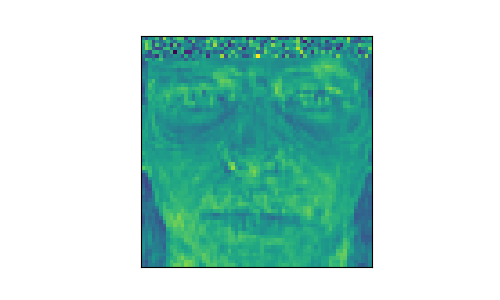

In [74]:
fig, ax = plt.subplots(1, figsize=[5,3])
ax.imshow(Vt[:,0].reshape(64,64))
cplt.clean_ax(ax)

<IPython.core.display.Javascript object>


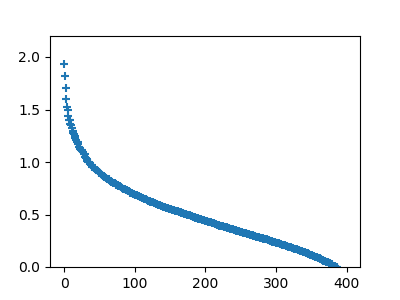

(0, 2.2)

In [62]:
fig,ax = plt.subplots(1, figsize=[4,3])
ax.scatter(list(range(len(S))), np.log10(S), marker='+')
ax.set_ylim([0,2.2])

<IPython.core.display.Javascript object>


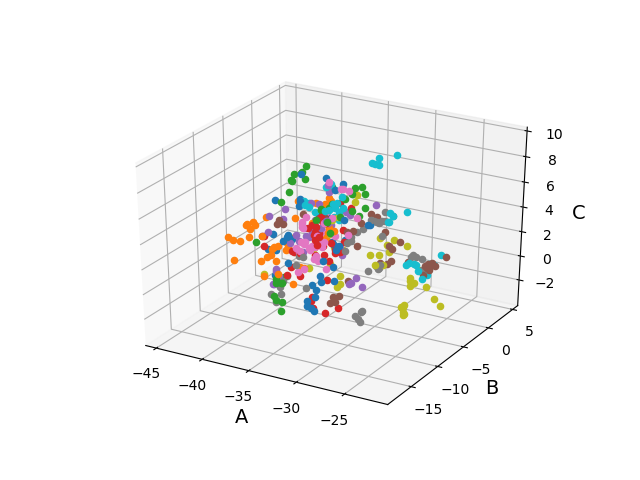

In [14]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## An example of protoclust

In [118]:
clustering, clustering_centers, clustering_distances\
    = pcl.protoclust(X,  lambda x,y: np.sqrt(np.sum(np.square(x-y))))

<IPython.core.display.Javascript object>


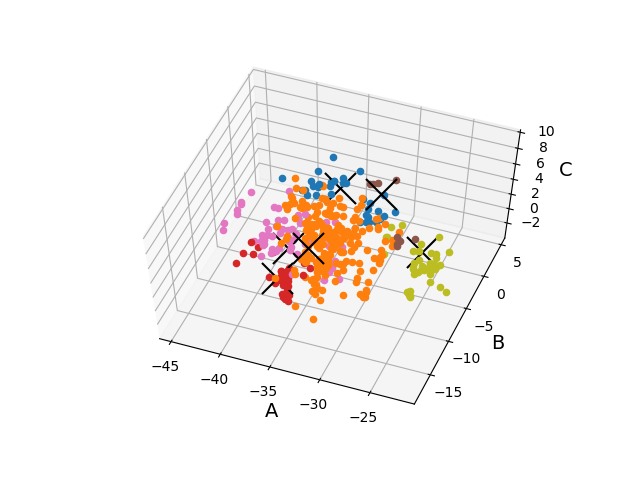

In [94]:
nk = 6

kclust = clustering[-nk]
kclust_center = clustering_centers[-nk]

colors, cnorm = [mpl.cm.get_cmap('tab10'), nk]

fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
for index, row in enumerate(pcX):
    c='gray'
    i,j,k = row
    for a, aclust in enumerate(kclust):
        if index in aclust:
            c=colors(a/cnorm)
    
    if index in kclust_center:
        ax.scatter(i,j,k,color='k', s=500, marker='x')
    else:
        ax.scatter(i,j,k,color=c)
    
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

In [92]:
clustering_distances[-nk]

[11.641844, 12.535541, 11.635705, 10.908246, 11.058519, 10.648919]

<IPython.core.display.Javascript object>


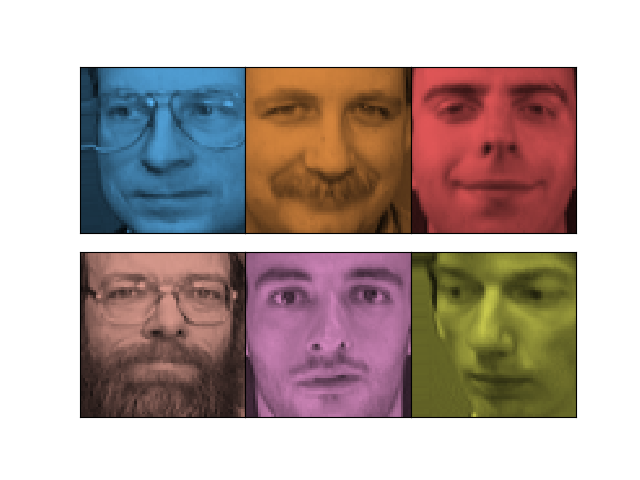

In [93]:
fig, ax = plt.subplots(2,3)
fig.subplots_adjust(wspace=0, hspace=0)
for i,row in enumerate(kclust_center):
    im = color.gray2rgb(X[row].reshape(64,64))
    c_hsv = rgb_to_hsv(*colors(i/cnorm)[:-1])
    ax.flatten()[i].imshow(cplt.colorize(im, c_hsv[0], .75*c_hsv[1]))
    cplt.clean_ax(ax.flatten()[i])

# Example 2: Words

In [96]:
from scipy.io import loadmat

In [119]:
words = loadmat('/home/andy/Downloads/grolier15276.mat')
X = words['grolier'].toarray()
n,d = X.shape

In [120]:
def pairwise_dissimilarity(x,y):
    return 1 - x@y/(np.linalg.norm(x)*np.linalg.norm(y))

In [121]:
clustering, clustering_centers, clustering_distances\
    = pcl.protoclust(X,  pairwise_dissimilarity)

KeyboardInterrupt: 